In [147]:
#Some libraries will be helpful to perform this program :)

import pandas as pd
import numpy as np
import numpy_financial as npf
import datetime
from dateutil.relativedelta import relativedelta
from decimal import Decimal
import matplotlib.pyplot as plt
import seaborn as sns

First thing to do is to write a class MortgageLoan with parameters like principal, duration, percentage, commission (commission may by included in principal or paid separately), first and last installment date. 

In [148]:
class MortgageLoan:
    
    
    def __init__(self, principal, duration, percentage, first_installment_date):
        

        self._principal = principal
        self._duration = duration
        self._percentage = percentage
        self._first_installment_date = first_installment_date
        self.last_installment_date = None
        

    @property
    def principal(self):
        return self._principal
        

    @principal.setter
    def principal(self, value):
        if value < 0:
            raise ValueError('Principal must be a positive int or float.')
            if not isinstance(value, (int, float)):
                raise TypeError('Principal must be type of int or float.')
            else:
                self._principal = value


    @property
    def duration(self):
        return self._duration
        

    @duration.setter
    def duration(self, value):
        if value < 0:
            raise ValueError('Duration must be a positive int.')
            if not isinstance(value, int):
                raise TypeError('Duration must be an int.')
            else:
                self._duration = value


    @property
    def percentage(self):
        return self._percentage
        
    
    
    @percentage.setter
    def percentage(self, value):
        if value < 0:
            raise ValueError('Percentage must be a positive int or float.')
            if not isinstance(value, (int, float)):
                raise TypeError('Percentage must be type of int or float.')
            else:
                self._percentage = value


    @property
    def commission_type(self):
        return self._commission_type
        

        
    @commission_type.setter
    def commission_type(self, value):
        if value in (0,1):
            self._commission_type = value
        else:
            raise ValueError(f'Commission type must be 0 or 1. 0 - for commission included in principal/n1 - for commission paid separately.')


    
    @property
    def first_installment_date(self):
         return self._first_installment_date
      
    
          
    @first_installment_date.setter
    def first_installment_date(self, value):
        self._first_installment_date = value
        if value != datetime.datetime.strptime(value, "%Y-%m-%d").strftime('%Y-%m-%d'):
            raise ValueError('First installment date must be a format of YYYY-MM-DD')
        else:
            self._first_installment_date = datetime.strptime(value, "%Y-%m-%d")
        
            
    @property
    def last_payment_date(self):
        if self.last_installment_date is None:
            self.last_installment_date = self.first_installment_date + relativedelta(months = self.duration)
        return self.last_installment_date

       

Most of mortgage loans are paid in annuity installments. It's a kind of loan which is characterized by constant payment each month. During the period of repayment, loaner pays different amounts of principal and interest - amount of principal is increasing and amount of interest is decreasing each month. Class AnnuityMortgage inhertis basic parameters from class MortgageLoan. This class also returns installment amount and repayment schedule. Schedule must contain inforation about principal and interest payment for each period of repayment.

In [188]:
class AnnuityMortgage(MortgageLoan):
    
    
    def __init__(self, principal, duration, percentage, first_installment_date):
        super().__init__(principal, duration, percentage, first_installment_date)

    
    def installment(self):
        return round(-1*(npf.pmt(self.percentage/12, self.duration, self.principal)),2)
    
                   
    def installment_table(self):
        schedule = [self.first_installment_date + relativedelta(months = i) for i in range(self.duration)]
        period = np.arange(self.duration) + 1
        interest_due = -1*(npf.ipmt(self.percentage/12, period, self.duration, self.principal))
        principal_payment = -1*(npf.ppmt(self.percentage/12, period, self.duration, self.principal))
        installment_timetable = pd.DataFrame({'Payment_date': schedule,
                                                  'Principal_amount': np.around(principal_payment, decimals = 2),
                                                  'Interest_payment': np.around(interest_due, decimals = 2),
                                                  'Installment_amount':[self.installment() for _ in range(self.duration)],
                                                  })
        return installment_timetable

Another kind of loan is a loan with decreasing installment. In this type of loan, loaner have to pay equal principal repayment and decreasing amount of interest. Class DecreasingMortgage also inherits basic parameters from class MortgageLoan nad returns value of first installment and repayment schedule. Schedule must contain inforation about principal and interest payment for each period of repayment.

In [152]:
class DecreasingMortgage(MortgageLoan):
    
    
    def __init__(self, principal, duration, percentage, first_installment_date):
        super().__init__(principal, duration, percentage, first_installment_date)
        

    def first_installment(self):
        return round(self.principal/self.duration + self.principal * self.percentage / 12,2)
    
        
    def installment_table(self):
        schedule = [self.first_installment_date + relativedelta(months = i) for i in range(self.duration)]
        period = np.arange(self.duration) + 1
        principal_payment = [round(self.principal/self.duration,2) for _ in range(self.duration)]
        principal_due = [self.principal - (self.principal/self.duration * i) for i in range(self.duration)]
        interest_due = [x * self.percentage/12 for x in principal_due]
        installment_amount = [round(a+b,2) for a,b in zip(interest_due, principal_payment)]
        installment_timetable = pd.DataFrame({'Payment_date': schedule,
                                              'Principal_amount': principal_payment,
                                              'Interest_payment': np.around(interest_due, decimals = 2),
                                              'Installment_amount': installment_amount
                                              })
        return installment_timetable
    

Here is space to specify mortgage's parametres, like principal, period of repayment and percentage. Program will compute your repayment schedule with specific information about each installment. It will also show what happen with your repayment schedule if interest rates will group up by 5 p.p. up.

In [221]:
#Here is the space to define parametres of the loan

pv = 280000 #principal to pay
r = 0.035 #interest rate
t = 300 #duration
start = datetime.date.today() #start date

annuitymortgage = AnnuityMortgage(pv,t, r, start)
annuitymortgage_schedule = annuitymortgage.installment_table() #Value to work with
first_annuity_installment = annuitymortgage.installment()
decreasingmortgage = DecreasingMortgage(pv,t, r, start)
decreasingmortgage_schedule = decreasingmortgage.installment_table() #Value to work with
first_decreasing_installment = decreasingmortgage.first_installment()

#Worse of scenario, if interest rates will grow up by 5 p.p up.

sad_annuitymortgage = AnnuityMortgage(pv,t, r+0.05, start)
sad_annuitymortgage_schedule = sad_annuitymortgage.installment_table() #Value to work with
sad_first_annuity_installment = sad_annuitymortgage.installment()
sad_decreasingmortgage = DecreasingMortgage(pv,t, r+0.05, start)
sad_decreasingmortgage_schedule = sad_decreasingmortgage.installment_table() #Value to work with
sad_first_decreasing_installment = sad_decreasingmortgage.first_installment()

print(f"Information about mortgage loan paid in {t} monthly annuity installments,"
      f"principal amount of {pv} and percentage of {r * 100:.2f}%. Amount of your installment is {first_annuity_installment}\n")
print(annuitymortgage_schedule.head())
print("\n")
print(f"Information about mortgage loan paid in {t} monthly decreasing installments"
      f"principal amount of {pv} and percentage of {r * 100:.2f}%. Amount of your first installment is {first_decreasing_installment}\n")
print(decreasingmortgage_schedule.head())

Information about mortgage loan paid in 300 monthly annuity installments,principal amount of 280000 and percentage of 3.50%. Amount of your installment is 1401.75

  Payment_date  Principal_amount  Interest_payment  Installment_amount
0   2022-01-22            585.08            816.67             1401.75
1   2022-02-22            586.79            814.96             1401.75
2   2022-03-22            588.50            813.25             1401.75
3   2022-04-22            590.21            811.53             1401.75
4   2022-05-22            591.94            809.81             1401.75


Information about mortgage loan paid in 300 monthly decreasing installmentsprincipal amount of 280000 and percentage of 3.50%. Amount of your first installment is 1750.0

  Payment_date  Principal_amount  Interest_payment  Installment_amount
0   2022-01-22            933.33            816.67             1750.00
1   2022-02-22            933.33            813.94             1747.27
2   2022-03-22          

In [156]:
#Annuity mortgage total interest - good scenario
annuity_total_interest = annuitymortgage_schedule["Interest_payment"].sum()

#Decreasing mortgage total interest - good scenario
decreasing_total_interest = decreasingmortgage_schedule["Interest_payment"].sum()

#Annuity mortgage total interest - bad scenario
sad_annuity_total_interest = sad_annuitymortgage_schedule["Interest_payment"].sum()

#Decreasing mortgage total interest - bad scenario
sad_decreasing_total_interest = sad_decreasingmortgage_schedule["Interest_payment"].sum()



print(f"For mortgage annuity installment you will pay {annuity_total_interest} in interest. If you have chosen "
      f"decreasing installment you would pay {decreasing_total_interest}. The difference is "
      f"{round(annuity_total_interest - decreasing_total_interest,2)}. Decreasing installment\n")

print(f"In case of interest rate growth of 5 p.p. up, total difference is: \n" 
      f"For annuity repayment scenario: {round(sad_annuity_total_interest - annuity_total_interest,2)}\n"
      f"For decreasing rapeyment scenario: {round(sad_decreasing_total_interest - decreasing_total_interest,2)}")
      

For mortgage annuity installment you will pay 140523.88 in interest. If you have chosen decreasing installment you would pay 122908.33. The difference is 17615.55. Decreasing installment mortgage is cheaper

In case of interest rate growth of 5 p.p. up, total difference is: 
For annuity repayment scenario: 255866.84
For decreasing rapeyment scenario: 175583.33


Finnaly, it's better to show inforation on charts. Now is the space to ask some Python's data science libraries to perform nice visualisations. Area chart will be amazing to present principal and interest payments. It's also interesting to see what happen if interest rats rise and what is the difference between annuity and decrasing installments. Bar chart will do good job for difference of annuity and decreasing installments. 

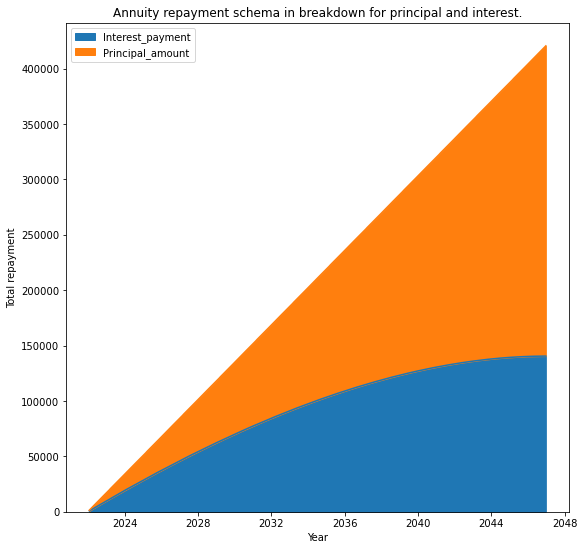

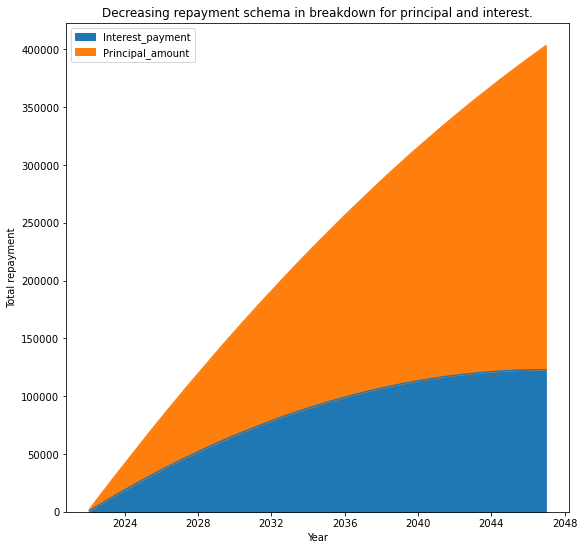

In [219]:
#Area chart for total cost of loan

df = pd.DataFrame(annuitymortgage_schedule, columns=['Payment_date', 'Interest_payment', 'Principal_amount'])\
    .set_index('Payment_date')\
    .sort_values('Payment_date')

pt = pd.pivot_table(df, index=['Payment_date'], values=['Interest_payment', 'Principal_amount'])
pt = pt.cumsum()
pt.plot.area(figsize = (7,7), xlabel = "Year", ylabel = "Total repayment")
plt.title('Annuity repayment schema in breakdown for principal and interest.')

df = pd.DataFrame(decreasingmortgage_schedule, columns=['Payment_date', 'Interest_payment', 'Principal_amount'])\
    .set_index('Payment_date')\
    .sort_values('Payment_date')

pt = pd.pivot_table(df, index=['Payment_date'], values=['Interest_payment', 'Principal_amount'])
pt = pt.cumsum()
pt.plot.area(figsize = (7,7), xlabel = "Year", ylabel = "Total repayment")
plt.title('Decreasing repayment schema in breakdown for principal and interest.')
plt.show()

<AxesSubplot:title={'center':'Change of decreasing installment if interest rates will rise.'}, xlabel='Scenario'>

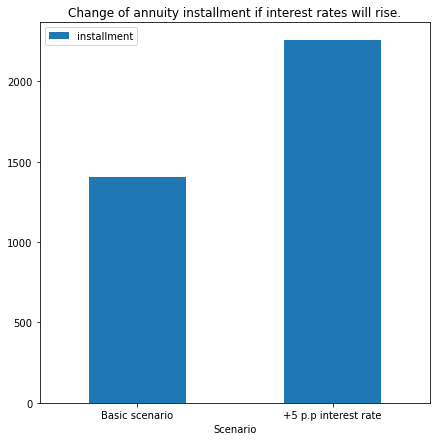

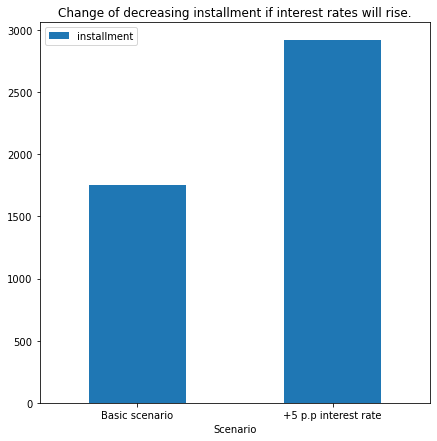

In [236]:
#Bar graph which show bad scenario of interest rates rise
bar_annuity = (first_annuity_installment, sad_first_annuity_installment)
bar_decreasing = (first_decreasing_installment, sad_first_decreasing_installment)


df = pd.DataFrame({'Scenario':['Basic scenario', '+5 p.p interest rate'], 'installment':bar_annuity})
df.plot.bar(x='Scenario', y='installment', rot=0, figsize = (7,7), title = 'Change of annuity installment if interest rates will rise.')


df = pd.DataFrame({'Scenario':['Basic scenario', '+5 p.p interest rate'], 'installment':bar_decreasing})
df.plot.bar(x='Scenario', y='installment', rot=0, figsize = (7,7), title = 'Change of decreasing installment if interest rates will rise.')


In [249]:
#Finally, you can download schedule as csv file for further analysis. Just use function below :)

def download_schedule():
    annuitymortgage_schedule.to_csv('annuityschedule.csv')
    decreasingmortgage_schedule.to_csv('decreasingschedule.csv')
    
download_schedule()